In [2]:
# data managment
import pandas as pd
import numpy as np
import scipy as sp
from lib.RegressorManager import *
from sklearn.externals import joblib
import os.path

# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# metrics
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import GridSearchCV

# plotting
from mpl_toolkits.mplot3d import Axes3D
from lib.PlotLearningCurve import plot_learning_curve
from matplotlib import pyplot as plt
import seaborn as sns
# learning
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection
from sklearn.neural_network import MLPClassifier


sns.set(color_codes=True)

In [2]:
%matplotlib notebook

In [3]:
from sklearn.externals.joblib import Parallel, parallel_backend, register_parallel_backend
import ipyparallel as ipp
from ipyparallel import Client
from ipyparallel.joblib import IPythonParallelBackend
c = ipp.Client()
print(c.ids)
bview = c.load_balanced_view()

# this is taken from the ipyparallel source code
register_parallel_backend('ipyparallel', lambda : IPythonParallelBackend(view=bview))

ModuleNotFoundError: No module named 'ipyparallel'

In [3]:
# load our train and test datasets
winemag_df = pd.read_csv("datasets/wine_reviews/winemag-data-130k-v2.csv")

In [4]:
fashion_df = pd.read_csv("datasets/fashion_mnist/fashion-mnist_train.csv")
fashion_df_test = pd.read_csv("datasets/fashion_mnist/fashion-mnist_test.csv")

In [6]:
fashion_df.shape

(60000, 785)

In [5]:
def gen_image(arr, ax=None):
    """
    function to display an mnist image from it's pixels array
    """
    image = np.array(arr, dtype='float')
    pixels = image.reshape((28, 28))
    if ax is None:
        plt.imshow(pixels, cmap='gray')
        plt.show()
    else:
        ax.imshow(pixels, cmap='gray')
    return ax

data preparation
----------------

first we need to clean the dataset, for this we will
 - select relevant columns
 - drop row containing na value (we can afford this because the ratio *number of row / input space dimension* is still good )
 - remove duplicate rows

In [4]:
X_winemag = winemag_df['description']
y_winemag = winemag_df['points']

In [6]:
(n_row, n_col) = fashion_df.values.shape
X_fashion = fashion_df.values[:, 1:n_col]
y_fashion = fashion_df.values[:, 0]
X_fashion_test = fashion_df_test.values[:, 1:n_col]
y_fashion_test = fashion_df_test.values[:, 0]

In [5]:
pipeline_wine = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer(use_idf=True))
    ]
)

In [10]:
pipeline_wine.fit(X_winemag, y_winemag)
X_winemag_trans = pipeline_wine.transform(X_winemag)
X_winemag_trans.shape

(129971, 31275)

Fashion MNIST
=======

kmeans
-------

In [5]:
param_grid = {'n_clusters': range(1,100)}

In [12]:
kmeans = KMeans()
clf = GridSearchCV(kmeans, param_grid, cv=2, verbose=1, n_jobs=-1)#, pre_dispatch=5)

In [6]:
if os.path.isfile('gridsearch_kmeans_fashion.pkl'):
    clf = joblib.load('gridsearch_kmeans_fashion.pkl')
else:
    with parallel_backend('ipyparallel'):
        clf.fit(X_fashion)
        joblib.dump(clf, 'gridsearch_kmeans_fashion.pkl')

/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual

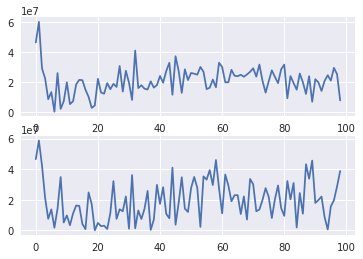

In [22]:
results = pd.DataFrame(data=clf.cv_results_)
fig, ax = plt.subplots(2,1)
ax[0].plot(results['std_train_score'])
ax[1].plot(results['std_test_score'])
plt.show()

In [10]:
np.argmax(results['std_test_score'][2:])

/home/thibaut/virtual_envs/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


58

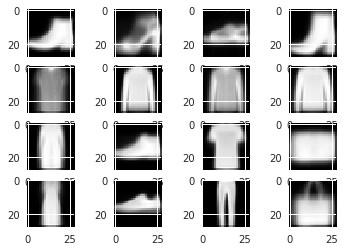

In [27]:
estimator = KMeans(n_clusters=16)
estimator.fit(X_fashion, y_fashion)


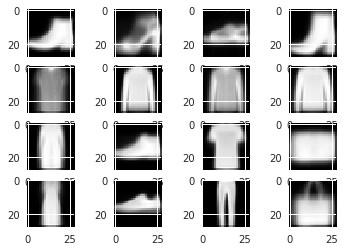

In [29]:

if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
else:
    components_ = estimator.components_
fig, ax = plt.subplots(4, 4)
i = 0
for comp in components_:
    gen_image(comp, ax[i % 4, int(i/4)])
    i += 1
plt.show()


EM
--

In [16]:
param_grid = {'n_components': range(1,100)}

In [17]:
gm = GaussianMixture()
clf = GridSearchCV(gm, param_grid, cv=2, verbose=1, n_jobs=-1)#, pre_dispatch=14)

In [10]:
if os.path.isfile('gridsearch_em_fashion.pkl'):
    clf = joblib.load('gridsearch_em_fashion.pkl')
else:
    with parallel_backend('ipyparallel'):
        clf.fit(X_fashion)
        joblib.dump(clf, 'gridsearch_em_fashion.pkl')

/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual_envs/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thibaut/virtual

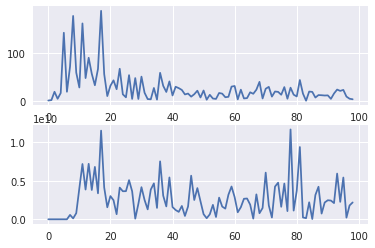

In [32]:
results = pd.DataFrame(data=clf.cv_results_)
fig, ax = plt.subplots(2,1)
ax[0].plot(results['std_train_score'])
ax[1].plot(results['std_test_score'])
plt.show()

In [33]:
estimator = clf.best_estimator_

{'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 100, 'means_init': None, 'n_components': 1, 'n_init': 1, 'precisions_init': None, 'random_state': None, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weights_init': None}


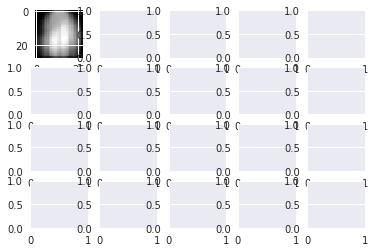

In [41]:

if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
elif hasattr(estimator, 'components_'):
    components_ = estimator.components_
else:
    components_ = estimator.means_
fig, ax = plt.subplots(4, 5)
i = 0
print(estimator.get_params())
for comp in components_:
    gen_image(comp, ax[i % 5, int(i/4)])
    i += 1
plt.show()


space study:
--------------

In [20]:
with parallel_backend('ipyparallel'):
    s = sp.linalg.svd(X_fashion, full_matrices=False, compute_uv=False)

<IPython.core.display.Javascript object>


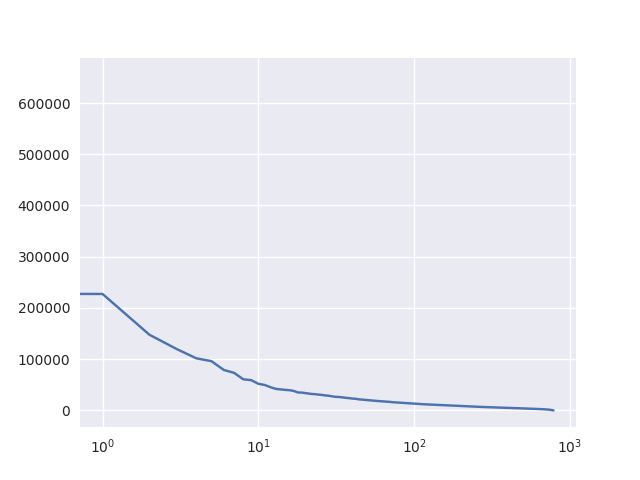

In [21]:
fig, ax = plt.subplots()
ax.plot(s)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [22]:
print(s[1])
print(s[10])
print(s[100])
print(s[-1])
print("cond:"+str(s[1]/s[100]))

227291.30971534885
51943.8797829287
13203.725005767896
19.565802247397535
cond:17.21418081761467


which dimension to use for reduction ?
 - 3 : to plot 3d graph
 - 9 : as we have 9 categories for classification
 - other : somewhat inspired by the haussler theorem

PCA reduction
--------------

In [23]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(X_fashion)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


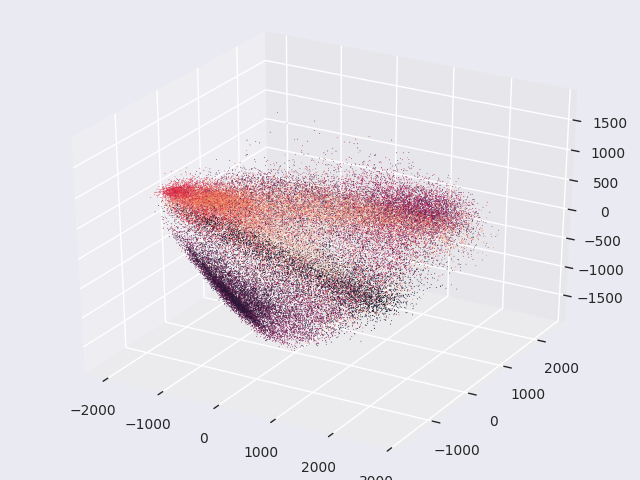

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
low_dim = pca.transform(X_fashion)
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_fashion, s=0.1)
plt.show()

In [7]:
estimator = PCA(n_components=36, svd_solver='full')
estimator.fit(X_fashion)

PCA(copy=True, iterated_power='auto', n_components=36, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

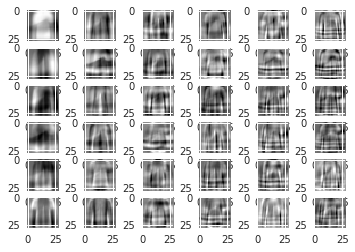

In [8]:
if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
else:
    components_ = estimator.components_
fig, ax = plt.subplots(6, 6)
i = 0
for comp in components_:
    gen_image(comp, ax[i % 6, int(i/6)])
    i += 1
plt.show()

ICA Reduction
---------------

In [25]:
with parallel_backend('ipyparallel'):
    ica = FastICA(n_components=3, algorithm='parallel')
    ica.fit(X_fashion, y_fashion)

<IPython.core.display.Javascript object>


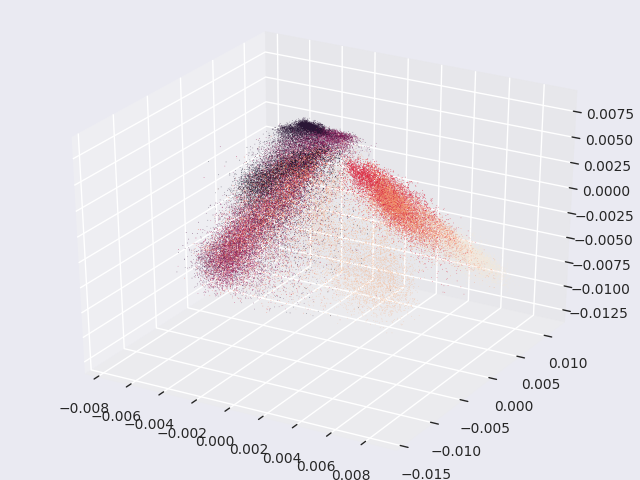

In [26]:
fig = plt.figure()
ax = Axes3D(fig)
low_dim = ica.transform(X_fashion)
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_fashion, s=0.05)
plt.show()

In [49]:
estimator = FastICA(n_components=36, algorithm='parallel')
estimator.fit(X_fashion, y_fashion)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=36, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

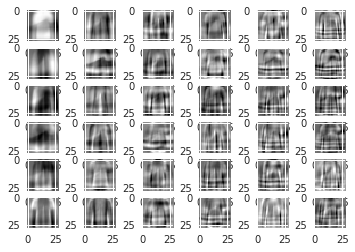

In [9]:

if hasattr(estimator, 'cluster_centers_'):
    components_ = estimator.cluster_centers_
else:
    components_ = estimator.components_
fig, ax = plt.subplots(6, 6)
i = 0
for comp in components_:
    gen_image(comp, ax[i % 6, int(i/6)])
    i += 1
plt.show()


Random projections
---------------------

In [7]:
johnson_lindenstrauss_min_dim(6*10E4, eps=0.5)

638

In [28]:
grp = GaussianRandomProjection(n_components=3)
grp.fit(X_fashion)

<IPython.core.display.Javascript object>


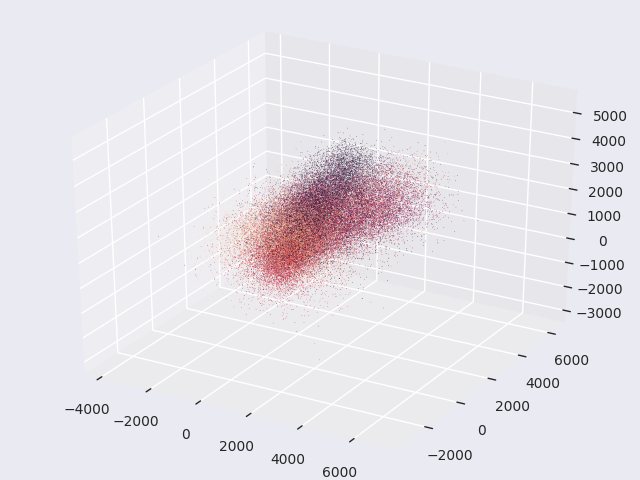

In [29]:
fig = plt.figure()
ax = Axes3D(fig)
low_dim = grp.transform(X_fashion)
ax.scatter(low_dim[:, 0], low_dim[:, 1], low_dim[:, 2], c=y_fashion, s=0.05)
plt.show()

In [30]:
nn = MLPClassifier(solver='adam', alpha=1e-5, max_iter=80000, hidden_layer_sizes=(50,50,50), random_state=1)
if os.path.isfile('nn_fashion.pkl'):
    nn = joblib.load('nn_fashion.pkl')
else:
    with parallel_backend('ipyparallel'):
        nn.fit(X_fashion, y_fashion)
        print(nn.score(X_fashion_test, y_fashion_test))
        joblib.dump(clf, 'nn_fashion.pkl')


In [32]:
pipeline_fashion = Pipeline(
    [
        ('ica', FastICA(algorithm='parallel')),
        ('nn', MLPClassifier(solver='adam', alpha=1e-5, max_iter=80000, hidden_layer_sizes=(50,50,50), random_state=1))
    ]
)
param_grid = {'ica__n_components': range(1,100,10)}
clf = GridSearchCV(pipeline_fashion, param_grid, cv=2, verbose=1, n_jobs=-1)#, pre_dispatch=14)

In [36]:
if os.path.isfile('grid_nn_fashion.pkl'):
    clf = joblib.load('grid_nn_fashion.pkl')
else:
    # with parallel_backend('ipyparallel'):
    clf.fit(X_fashion, y_fashion)  # , n_jobs=4, pre_dispatch=1)
    joblib.dump(clf, 'grid_nn_fashion.pkl')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.0min finished


In [8]:
pipeline_fashion = Pipeline(
    [
        ('pca', PCA(svd_solver='full')),
        ('nn', MLPClassifier(solver='adam', alpha=1e-5, max_iter=80000, hidden_layer_sizes=(50,50,50), random_state=1))
    ]
)
param_grid = {'pca__n_components': range(1,100,10)}
clf = GridSearchCV(pipeline_fashion, param_grid, cv=2, verbose=1, n_jobs=5 , pre_dispatch=5)
if os.path.isfile('pca_nn_fashion.pkl'):
    clf = joblib.load('pca_nn_fashion.pkl')
else:
    # with parallel_backend('ipyparallel'):
    clf.fit(X_fashion, y_fashion)  # , n_jobs=4, pre_dispatch=1)
    joblib.dump(clf, 'pca_nn_fashion.pkl')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


In [9]:
pipeline_fashion = Pipeline(
    [
        ('rp', GaussianRandomProjection()),
        ('nn', MLPClassifier(solver='adam', alpha=1e-5, max_iter=80000, hidden_layer_sizes=(50,50,50), random_state=1))
    ]
)
param_grid = {'rp__n_components': range(1,100,10)}
clf = GridSearchCV(pipeline_fashion, param_grid, cv=2, verbose=1, n_jobs=5 , pre_dispatch=5)
if os.path.isfile('rp_nn_fashion.pkl'):
    clf = joblib.load('rp_nn_fashion.pkl')
else:
    # with parallel_backend('ipyparallel'):
    clf.fit(X_fashion, y_fashion)  # , n_jobs=4, pre_dispatch=1)
    joblib.dump(clf, 'rp_nn_fashion.pkl')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   40.9s finished


In [7]:
pipeline_fashion = Pipeline(
    [
        ('km', KMeans()),
        ('nn', MLPClassifier(solver='adam', alpha=1e-5, max_iter=80000, hidden_layer_sizes=(50,50,50), random_state=1))
    ]
)
param_grid = {'km__n_clusters': range(1,100,10)}
clf = GridSearchCV(pipeline_fashion, param_grid, cv=2, verbose=1, n_jobs=5 , pre_dispatch=5)
if os.path.isfile('km_nn_fashion.pkl'):
    clf = joblib.load('km_nn_fashion.pkl')
else:
    # with parallel_backend('ipyparallel'):
    clf.fit(X_fashion, y_fashion) #, n_jobs=16, pre_dispatch=16)
    joblib.dump(clf, 'km_nn_fashion.pkl')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.2min finished


In [6]:
class GaussianMixtureTransform(GaussianMixture):
    def transform(self, X):
        return self.predict(X).reshape(-1, 1)

In [ ]:
pipeline_fashion = Pipeline(
    [
        ('em', GaussianMixtureTransform()),
        ('nn', MLPClassifier(solver='adam', alpha=1e-5, max_iter=80000, hidden_layer_sizes=(50,50,50), random_state=1))
    ]
)
param_grid = {'em__n_components': range(1,100,10)}
clf = GridSearchCV(pipeline_fashion, param_grid, cv=2, verbose=1, n_jobs=5, pre_dispatch=5)
if os.path.isfile('em_nn_fashion.pkl'):
    clf = joblib.load('em_nn_fashion.pkl')
else:
    #with parallel_backend('ipyparallel'):
    clf.fit(X_fashion, y_fashion)  # , n_jobs=4, pre_dispatch=1)
    joblib.dump(clf, 'em_nn_fashion.pkl')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


Wine reviews
=======

In [32]:
with parallel_backend('ipyparallel'):
    (_, s2, _) = sp.sparse.linalg.svds(X_winemag_trans, k=1000, return_singular_vectors=True)

In [33]:
s2.dump("wine_sv.pkl")

1854.1036782231256


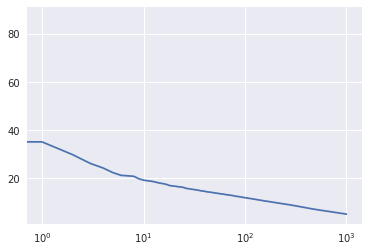

In [34]:
print(sp.sum(s2)/sp.sum(X_winemag_trans.diagonal()))
fig, ax = plt.subplots()
ax.plot(s2[::-1])
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()